# Image Assembly

Converting raw scanimage-tiff files into fused z-planes.

There are two computational efforts made during extraction:

- Scan-phase correction (fix_phase=True)
- Axial alignment / registration (z_register=True)


```python

# quickstart
import mbo_utilities as mbo

scan = mbo.imread(r"path/to/tiffs*")  # glob or list of filepaths

# Save options:
scan.roi = 1            # save just mROI 1
scan.roi = [1, 2]       # save mROI 1 and 2
scan.roi = 0            # save all mROIs separately
scan.roi = None         # stitch/fuse all mROIs
scan.fix_phase = True   # correct bi-dir scan-phase
scan.use_fft = True     # subpixel scan-phase correction

mbo.imwrite(scan, "/path/to/save", planes=[1, 7, 14], ext=".tiff")
# Creates: plane_01.tiff, plane_07.tiff, plane_14.tiff
```

In [14]:
from pathlib import Path
import numpy as np

import fastplotlib as fpl
import mbo_utilities as mbo
import matplotlib.pyplot as plt

## Read data with `mbo.imread()`

```{important}

Make sure your `data_path` contains only `.tiff` files for this imaging session. If there are other `.tiff` files, such as from another session or a processed file for this session, those files will be included in the scan and lead to errors.

```

Pass a list of files, or a wildcard string (e.g. "/path/to/files/*" matches all files in that directory) to `mbo.imread()`.

In [11]:
raw_scanimage_tiffs = mbo.get_files(Path(r"\\rbo-s1\S1_DATA\lbm\demo_user\raw_scanimage_tiffs"))
len(raw_scanimage_tiffs)

50

In [20]:
scan = mbo.imread(raw_scanimage_tiffs)

Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
print(f'Planes: {scan.num_channels}')
print(f'Frames: {scan.num_frames}')
print(f'ROIs: {scan.num_rois}')
print(f'Shape (T, Z, Y, X): {scan.shape}')

Planes: 14
Frames: 5632
ROIs: 2
Shape (T, Z, Y, X): (5632, 14, 448, 448)


## Metadata

`mbo.imread` automatically collects all available metadata in the file. 

This metadata reflects information on all the options selected and otherwise available in ScanImage, for an image acquisition, as well as specific parameters that pertain to the current parameter set e.g. number of rois, number of frames, scan-phase correction properties, etc.

There is a **lot** of ScanImage metadata, even after cleaning empty values.

To view metadata, it's helpful to use [pprint](https://docs.python.org/3/library/pprint.html) so that the scanimage metadata doesn't flood the terminal.

In [26]:
from pprint import pprint

# "si" contains nested scanimage metadata
pprint(scan.metadata, depth=1)

{'border': 3,
 'dtype': 'int16',
 'file_paths': [...],
 'fix_phase': True,
 'fov': [...],
 'fov_px': [...],
 'frame_rate': 17.06701142272251,
 'frames_per_file': [...],
 'max_offset': 4,
 'ndim': 2,
 'num_files': 50,
 'num_fly_to_lines': 16,
 'num_frames': 5632,
 'num_planes': 14,
 'num_rois': 2,
 'objective_resolution': 61,
 'offset': 0.0,
 'page_height': 912,
 'page_width': 224,
 'phasecorr_method': 'mean',
 'pixel_resolution': [...],
 'roi_groups': [...],
 'roi_heights': [...],
 'si': {...},
 'size': 204288,
 'uniform_sampling': 1,
 'upsample': 5,
 'use_fft': False,
 'zoom_factor': 2}


## Accessing data in the scan

Numpy-like indexing:

```python
frame = scan[0, 0, :, :]   # first frame, plane 1
zplane7 = scan[:, 6, :, :] # all frames from z-plane 7
```

RFBOutputContext()

JupyterRenderCanvas(css_height='1200.0px', css_width='1000.0px')
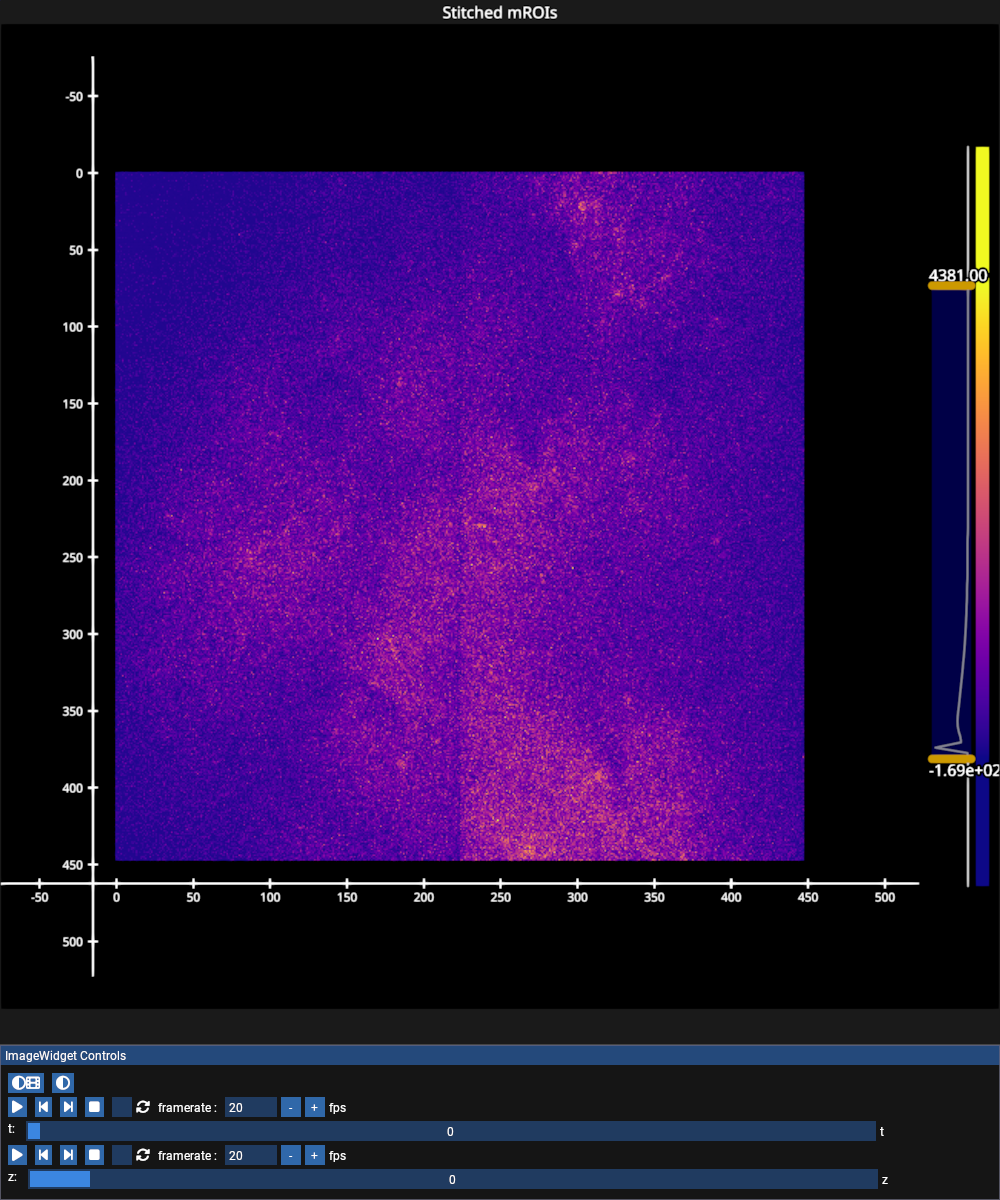

In [8]:
# !! Jupyter Only
iw = scan.imshow()
iw.show()

In [9]:
iw.close()

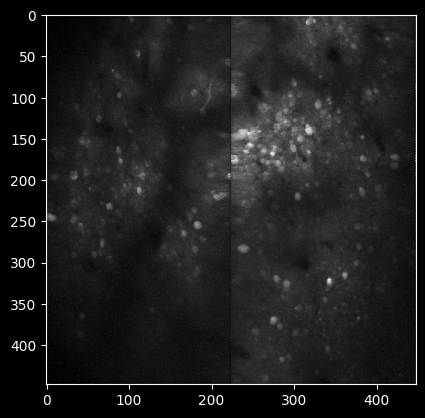

In [15]:
# max-projection

scan.roi = None
plt.imshow(scan[:,7,:,:].max(axis=0), cmap='gray')

1. No scan-phase correction

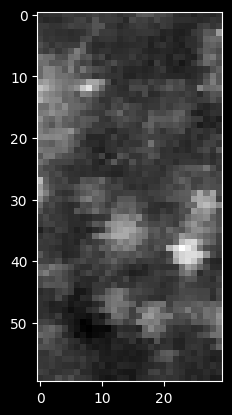

In [27]:
scan.fix_phase = False
scan.roi = None
plt.imshow(scan[:,7,:,:].max(axis=0)[130:190, 250:280], cmap='gray')


2. No-FFT scan-phase correction (better)

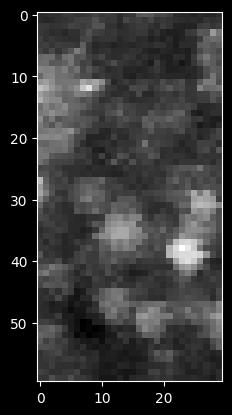

In [28]:
scan.fix_phase = True
scan.use_fft = False
plt.imshow(scan[:,7,:,:].max(axis=0)[130:190, 250:280], cmap='gray')

3. FFT scan-phase correction (best, computationally expensive)

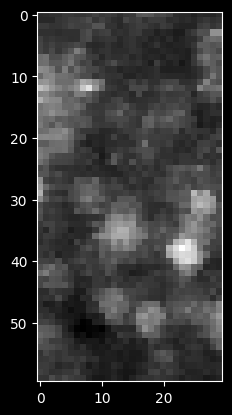

In [29]:
scan.fix_phase = True
scan.use_fft = True
plt.imshow(scan[:,7,:,:].max(axis=0)[130:190, 250:280], cmap='gray')

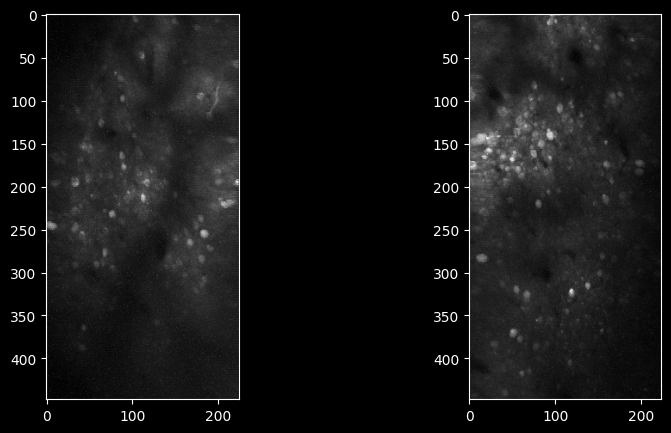

In [30]:
# returns a tuple of all rois
scan.roi = 0
mroi1, mroi2 = scan[:,7,:,:]

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(mroi1.max(axis=0), cmap='gray')
ax[1].imshow(mroi2.max(axis=0), cmap='gray')

## Save assembled files

The currently supported file extensions are `.tiff`, `.bin`, `.zarr`, and `.h5`.

We recommend `.zarr` for the fastest I/O speeds, or `.bin` if using Suite2p downstream.

### Basic Usage: Stitch ROIs and Save All Planes

In [34]:
# get full documentation
help(mbo.imwrite)

Help on function imwrite in module mbo_utilities.lazy_array:

imwrite(lazy_array, outpath: 'str | Path', ext: 'str' = '.tiff', planes: 'list | tuple | None' = None, num_frames: 'int | None' = None, register_z: 'bool' = False, roi: 'int | Sequence[int] | None' = None, metadata: 'dict | None' = None, overwrite: 'bool' = False, order: 'list | tuple' = None, target_chunk_mb: 'int' = 20, progress_callback: 'Callable | None' = None, debug: 'bool' = False, shift_vectors: 'np.ndarray | None' = None, **kwargs)
    Write a supported lazy imaging array (Suite2p, HDF5, TIFF, etc.) to disk.

    This function handles writing multi-dimensional imaging data to various formats,
    with support for ROI selection, z-plane registration, chunked streaming, and
    format conversion. Use with `imread()` to load and convert imaging data.

    Parameters
    ----------
    lazy_array : object
        One of the supported lazy array readers providing `.shape`, `.metadata`,
        and `_imwrite()` methods:



In [ ]:
save_path = Path(r"\\rbo-s1\S1_DATA\lbm\demo_user\extracted")

scan.roi = None       # Stitch all ROIs together (default behavior)
scan.fix_phase = True
scan.use_fft = True

mbo.imwrite(
    scan,
    save_path,
    ext='.bin',
    num_frames=1550,
    planes=[6, 7, 8],
    overwrite=True,
    register_z=True  # suite3d axial registration
)
# Creates: plane01_stitched/data_raw.bin, plane02_stitched/data_raw.bin
# Compatible with LBM-Suite2p-Python

    Loaded file into shared memory in 1.68 sec
    Workers completed in 1.89 sec
    Total time: 3.57 sec


Saving data_raw.bin:   0%|          | 0/108 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/108 [00:00<?, ?it/s]

### Save Specific Planes

In [ ]:
# Save only first, middle, and last planes (for 14-plane volume)
mbo.imwrite(
    scan,
    save_path,
    planes=[1, 7, 14],
    overwrite=False,
    ext='.tiff'
)
# Creates: plane01_stitched.tiff, plane07_stitched.tiff, plane14_stitched.tiff

### ROI Handling Options

In [ ]:
# Option 1: Stitch all ROIs together (default)
scan.roi = None
mbo.imwrite(scan, save_path / "stitched")
# Creates: plane01_stitched.tiff, plane02_stitched.tiff, ...

# Option 2: Save all ROIs as separate files
scan.roi = 0
mbo.imwrite(scan, save_path / "split_rois")
# Creates: plane01_roi1.tiff, plane01_roi2.tiff, ..., plane14_roi1.tiff, plane14_roi2.tiff

# Option 3: Save specific ROI only
scan.roi = 1
mbo.imwrite(scan, save_path / "roi1_only")
# Creates: plane01_roi1.tiff, plane02_roi1.tiff, ..., plane14_roi1.tiff

# Option 4: Save multiple specific ROIs
scan.roi = [1, 3]
mbo.imwrite(scan, save_path / "roi1_and_roi3")
# Creates: plane01_roi1.tiff, plane01_roi3.tiff, ..., plane14_roi1.tiff, plane14_roi3.tiff

### Enable Phase Correction

Fix bidirectional scan phase artifacts before saving:

In [ ]:
scan.fix_phase = True
scan.phasecorr_method = "mean"  # Options: "mean", "median", "max"
scan.use_fft = True  # Use FFT-based correction (faster)
mbo.imwrite(scan, save_path / "phase_corrected")

### Z-Plane Registration

Align z-planes spatially using Suite3D registration:

In [ ]:
# Automatic registration with Suite3D (requires Suite3D + CuPy installed)
mbo.imwrite(
    scan,
    save_path / "registered",
    register_z=True,
    roi=None
)
# Computes rigid shifts and applies them during write
# Validates registration results before proceeding

### Export Subset of Frames

Useful for testing or creating demos:

In [ ]:
# Export only first 1000 frames
mbo.imwrite(scan, save_path / "test_data", num_frames=1000, planes=[1, 7, 14])

### Convert to Suite2p Binary Format

In [ ]:
# Save as Suite2p-compatible binary files
mbo.imwrite(scan, save_path / "suite2p", ext='.bin', roi=0)
# Creates: plane01_roi1/data_raw.bin + ops.npy, plane01_roi2/data_raw.bin + ops.npy, ...

### Save to Zarr Format

In [ ]:
# Save as Zarr v3 stores (efficient for large datasets)
mbo.imwrite(scan, save_path / "zarr_data", ext='.zarr', roi=0)
# Creates: plane01_roi1.zarr, plane01_roi2.zarr, ...

### Use Pre-Computed Registration Shifts

*In progress*

In [ ]:
# Load previously computed shifts
# import numpy as np
# summary = np.load("previous_job/summary/summary.npy", allow_pickle=True).item()
# shift_vectors = summary['plane_shifts']  # shape: (n_planes, 2)

# # Apply shifts without re-running registration
# mbo.imwrite(scan, save_path / "registered", shift_vectors=shift_vectors)

## Visualize data with [fastplotlib](https://www.fastplotlib.org/user_guide/guide.html#what-is-fastplotlib)

To get a rough idea of the quality of your extracted timeseries, we can create a fastplotlib visualization to preview traces of individual pixels.

Here, we simply click on any pixel in the movie, and we get a 2D trace (or "temporal component" as used in this field) of the pixel through the course of the movie:

More advanced visualizations can be easily created, i.e. adding a baseline subtracted element to the trace, or passing the trace through a frequency filter.

In [ ]:
import tifffile
from ipywidgets import VBox

img = mbo.imread("path/to/assembled/plane07_stitched.tiff")
iw_movie = fpl.ImageWidget(img, cmap="viridis")

tfig = fpl.Figure()

raw_trace = tfig[0, 0].add_line(np.zeros(img.shape[0]))

@iw_movie.managed_graphics[0].add_event_handler("click")
def pixel_clicked(ev):
    col, row = ev.pick_info["index"]
    raw_trace.data[:, 1] = iw_movie.data[0][:, row, col]
    tfig[0, 0].auto_scale(maintain_aspect=False)

VBox([iw_movie.show(), tfig.show()])